In [3]:
pip install opendatasets

In [4]:
# Importing libraries
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

In [5]:
od.download("https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tweakspurpose
Your Kaggle Key: ··········


100%|██████████| 5.20G/5.20G [04:03<00:00, 23.0MB/s]


# Pre-processing Image

In [6]:
# Reading the data
path = '/content/skin-cancer-mnist-ham10000'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [7]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'

}

In [8]:
# Reading Metadata csv file
skin_df = pd.read_csv('/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [9]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [10]:
# Checking the dataframe info.
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [11]:
# Image Reading and Resizing.
IMAGE_SIZE = 71
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [01:34<00:00, 106.26it/s]


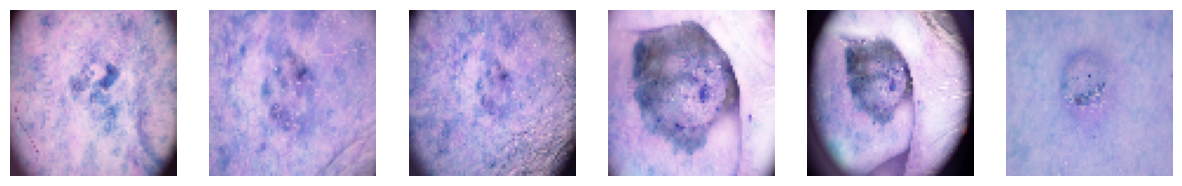

In [12]:
#Visulaizing the images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(train_img[i])
    plt.axis('off')
plt.show()

In [13]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 71, 71, 3)


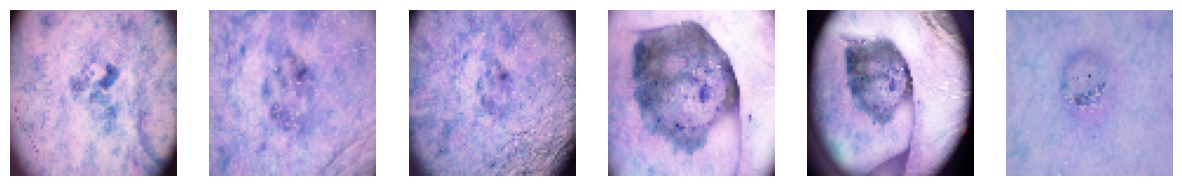

In [14]:
#Visulaizing the normalized images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [15]:
# Creating Target
y = np.array(skin_df['cell_type_idx'])

In [16]:
# Splitting the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Creating CNN Model

In [18]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [19]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

# Assuming y_train and y_val are integer labels
# Make sure your labels start from 0 and are contiguous integers.

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Now, y_train_encoded and y_val_encoded are integer-encoded labels.

# Example:
# If your labels are [2, 0, 1, 1, 2, 0], you need to convert them to [1, 0, 2, 2, 1, 0]
# You can use LabelEncoder for this purpose.

num_classes = len(label_encoder.classes_)

# Create a model with Xception base
training_shape = (71, 71, 3)
base_model = Xception(include_top=False, weights='imagenet', input_shape=training_shape)

# Set the base model layers to be trainable
for layer in base_model.layers:
    layer.trainable = True

# Example of adding classification layers on top of Xception
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model (add optimizer, loss, metrics as needed)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 [==============================] - 4s 0us/step


In [20]:
#Adding layers at end
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [21]:
# Compiling the model
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [22]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 35, 35, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 35, 35, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 35, 35, 32)           0         ['block1_conv1_bn[0][0]'] 

In [23]:
# Defining callback Methods
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [24]:
# Example of adding classification layers on top of Xception
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))  # Ensure the number of units matches num_classes

# Compile the model (add optimizer, loss, metrics as needed)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/30
254/254 [==============================] - 69s 94ms/step - loss: 0.8200 - accuracy: 0.7153 - val_loss: 15.8404 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 2/30
254/254 [==============================] - 20s 78ms/step - loss: 0.6244 - accuracy: 0.7777 - val_loss: 0.7153 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 3/30
254/254 [==============================] - 20s 79ms/step - loss: 0.5052 - accuracy: 0.8212 - val_loss: 0.9326 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 4/30
254/254 [==============================] - 21s 85ms/step - loss: 0.3989 - accuracy: 0.8566 - val_loss: 0.8678 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 5/30
254/254 [==============================] - 21s 81ms/step - loss: 0.3178 - accuracy: 0.8861 - val_loss: 0.7798 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/30
254/254 [==============================] - 21s 82ms/step - loss: 0.2483 - accuracy: 0.9179 - val_loss: 0.7128 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 7/30
254/254 [==============================] - 21s

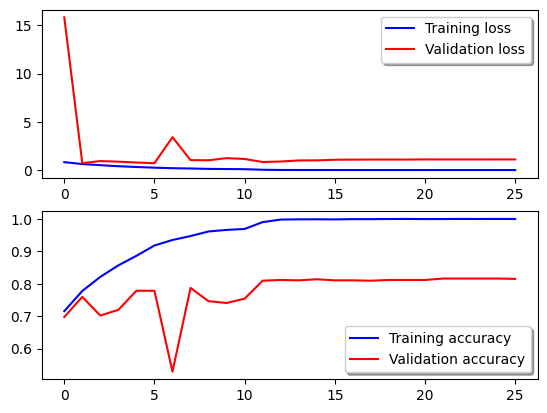

In [25]:
# Fitting the model
history = model.fit(x_train,
                    y_train_encoded,
                    epochs=n_epoch,
                    callbacks=[reduce_lr, early_stop],
                    validation_data=(x_val, y_val_encoded)
                   )

# Plotting the results on Graph
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [44]:
# Assuming you have a set of new data for predictions stored in the variable x_test
predictions = model.predict(x_test)

# The 'predictions' variable now contains the predicted probabilities for each class
# If you want the predicted class (index with the highest probability), you can use argmax
predicted_classes = predictions.argmax(axis=1)

# If you have class labels, you might want to inverse transform them using the label encoder
predicted_labels = label_encoder.inverse_transform(predicted_classes)


32/32 [==============================] - 2s 39ms/step


In [45]:
print(len(predictions[0]))

7


In [46]:
X[0]


array([[[0.76862746, 0.60784316, 0.7529412 ],
        [0.75686276, 0.6       , 0.74509805],
        [0.75686276, 0.5764706 , 0.7529412 ],
        ...,
        [0.6784314 , 0.6313726 , 0.7764706 ],
        [0.6156863 , 0.58431375, 0.75686276],
        [0.6627451 , 0.61960787, 0.7607843 ]],

       [[0.7254902 , 0.5647059 , 0.7529412 ],
        [0.7254902 , 0.60784316, 0.7490196 ],
        [0.7882353 , 0.62352943, 0.76862746],
        ...,
        [0.61960787, 0.60784316, 0.77254903],
        [0.5921569 , 0.5882353 , 0.75686276],
        [0.64705884, 0.5921569 , 0.7607843 ]],

       [[0.7490196 , 0.60784316, 0.74509805],
        [0.77254903, 0.62352943, 0.77254903],
        [0.7764706 , 0.6313726 , 0.76862746],
        ...,
        [0.6313726 , 0.59607846, 0.7647059 ],
        [0.60784316, 0.58431375, 0.7647059 ],
        [0.5686275 , 0.5529412 , 0.72156864]],

       ...,

       [[0.68235296, 0.54509807, 0.6784314 ],
        [0.68235296, 0.57254905, 0.70980394],
        [0.7058824 , 0

In [47]:
# Concatenating the predictions with final dataframe
data_df  = skin_df
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.757096e-04,2.501633e-04,0.048213,0.000028,0.016350,0.934364,0.000119
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.839102e-03,7.538759e-03,0.603392,0.001097,0.371377,0.009534,0.000221
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,4.013555e-03,1.211547e-02,0.047677,0.020053,0.851110,0.059602,0.005428
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,2.568609e-07,4.520819e-07,0.000143,0.000017,0.999801,0.000019,0.000020
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,1.072368e-01,5.027071e-01,0.099582,0.019079,0.067725,0.131517,0.072153


In [49]:
# Save the model
model.save('my_cnn_model.h5')

# Download the saved model file
from google.colab import files
files.download('my_cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# Save only the model architecture
model_json = model.to_json()
with open('my_cnn_model.json', 'w') as json_file:
    json_file.write(model_json)

# Download the saved model architecture file
files.download('my_cnn_model.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('my_cnn_model.h5')
# or, if you saved only the architecture
# loaded_model = model_from_json(open('my_cnn_model.json').read())


In [52]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.757096e-04,2.501633e-04,0.048213,0.000028,0.016350,0.934364,0.000119
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.839102e-03,7.538759e-03,0.603392,0.001097,0.371377,0.009534,0.000221
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,4.013555e-03,1.211547e-02,0.047677,0.020053,0.851110,0.059602,0.005428
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,2.568609e-07,4.520819e-07,0.000143,0.000017,0.999801,0.000019,0.000020
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,1.072368e-01,5.027071e-01,0.099582,0.019079,0.067725,0.131517,0.072153


In [53]:
complete_data.columns

Index([    'lesion_id',      'image_id',            'dx',       'dx_type',
                 'age',           'sex',  'localization',          'path',
           'cell_type', 'cell_type_idx',               0,               1,
                     2,               3,               4,               5,
                     6],
      dtype='object')

In [54]:
#One-hot encoding categorical variables in dataframe
dxtype_df = pd.get_dummies(complete_data['dx_type'],drop_first=False)
complete_data = pd.concat([dxtype_df,complete_data],axis=1)
complete_data.head()

,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,age,sex,...,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,0,0,0,1,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.757096e-04,2.501633e-04,0.048213,0.000028,0.016350,0.934364,0.000119
1,0,0,0,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.839102e-03,7.538759e-03,0.603392,0.001097,0.371377,0.009534,0.000221
2,0,0,0,1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,4.013555e-03,1.211547e-02,0.047677,0.020053,0.851110,0.059602,0.005428
3,0,0,0,1,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,2.568609e-07,4.520819e-07,0.000143,0.000017,0.999801,0.000019,0.000020
4,0,0,0,1,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,...,/content/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,1.072368e-01,5.027071e-01,0.099582,0.019079,0.067725,0.131517,0.072153


In [55]:
local_df = pd.get_dummies(complete_data['localization'],drop_first=False)
complete_data = pd.concat([local_df,complete_data],axis=1)
complete_data.head()

,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,...,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,0,0,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.757096e-04,2.501633e-04,0.048213,0.000028,0.016350,0.934364,0.000119
1,0,0,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.839102e-03,7.538759e-03,0.603392,0.001097,0.371377,0.009534,0.000221
2,0,0,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,4.013555e-03,1.211547e-02,0.047677,0.020053,0.851110,0.059602,0.005428
3,0,0,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,2.568609e-07,4.520819e-07,0.000143,0.000017,0.999801,0.000019,0.000020
4,0,0,0,0,1,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,1.072368e-01,5.027071e-01,0.099582,0.019079,0.067725,0.131517,0.072153


In [56]:
sex_df = pd.get_dummies(complete_data['sex'],drop_first=False)
sex_df.drop(['unknown'],axis=1,inplace=True)
complete_data = pd.concat([sex_df,complete_data],axis=1)
complete_data.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,0,1,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.757096e-04,2.501633e-04,0.048213,0.000028,0.016350,0.934364,0.000119
1,0,1,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,6.839102e-03,7.538759e-03,0.603392,0.001097,0.371377,0.009534,0.000221
2,0,1,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,4.013555e-03,1.211547e-02,0.047677,0.020053,0.851110,0.059602,0.005428
3,0,1,0,0,0,0,0,0,0,0,...,/content/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,2.568609e-07,4.520819e-07,0.000143,0.000017,0.999801,0.000019,0.000020
4,0,1,0,0,0,0,1,0,0,0,...,/content/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,1.072368e-01,5.027071e-01,0.099582,0.019079,0.067725,0.131517,0.072153


In [57]:
# Dropping variables since we have encoded them.
X_labels = complete_data.drop(['lesion_id','image_id','dx_type','dx','path','cell_type','cell_type_idx','sex','path','localization'],axis=1,inplace=False)
y_label = complete_data['cell_type_idx']

In [58]:
X_labels.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,follow_up,histo,age,0,1,2,3,4,5,6
0,0,1,0,0,0,0,0,0,0,0,...,0,1,80.0,6.757096e-04,2.501633e-04,0.048213,0.000028,0.016350,0.934364,0.000119
1,0,1,0,0,0,0,0,0,0,0,...,0,1,80.0,6.839102e-03,7.538759e-03,0.603392,0.001097,0.371377,0.009534,0.000221
2,0,1,0,0,0,0,0,0,0,0,...,0,1,80.0,4.013555e-03,1.211547e-02,0.047677,0.020053,0.851110,0.059602,0.005428
3,0,1,0,0,0,0,0,0,0,0,...,0,1,80.0,2.568609e-07,4.520819e-07,0.000143,0.000017,0.999801,0.000019,0.000020
4,0,1,0,0,0,0,1,0,0,0,...,0,1,75.0,1.072368e-01,5.027071e-01,0.099582,0.019079,0.067725,0.131517,0.072153


# CNN Predictions

In [59]:
# Making predictions from CNN
complete_data.to_csv('skin_cancer_v2.csv')
preds = model.predict(x_test)
preds

32/32 [==============================] - 1s 23ms/step


array([[6.7570963e-04, 2.5016331e-04, 4.8212752e-02, ..., 1.6350288e-02,
        9.3436432e-01, 1.1870168e-04],
       [6.8391017e-03, 7.5387587e-03, 6.0339212e-01, ..., 3.7137678e-01,
        9.5344838e-03, 2.2142708e-04],
       [4.0135551e-03, 1.2115473e-02, 4.7677241e-02, ..., 8.5110998e-01,
        5.9602037e-02, 5.4282760e-03],
       ...,
       [8.1434282e-06, 2.0428655e-05, 1.1887203e-03, ..., 9.9005961e-01,
        8.6958138e-03, 6.7974347e-06],
       [5.1124650e-04, 9.7136083e-04, 2.1599214e-01, ..., 7.6784861e-01,
        1.4334106e-02, 6.8995185e-05],
       [5.4133474e-04, 4.7261087e-04, 2.0299330e-02, ..., 3.0776381e-01,
        6.7036104e-01, 4.4547883e-04]], dtype=float32)

In [60]:
lst = []
for a in preds:
    lst.append(np.argmax(a))

In [61]:
lst

[5,
 2,
 4,
 4,
 1,
 2,
 4,
 4,
 1,
 0,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 1,
 5,
 4,
 4,
 4,
 6,
 0,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 2,
 5,
 5,
 4,
 5,
 2,
 4,
 0,
 5,
 4,
 2,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 6,
 1,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 4,
 4,
 4,
 4,
 2,
 2,
 5,
 2,
 4,
 1,
 4,
 4,
 4,
 1,
 2,
 4,
 0,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 1,
 4,
 4,
 4,
 2,
 4,
 4,
 0,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 2,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 2,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 2,
 4,
 3,
 4,
 0,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 2,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 5,
 2,
 4,
 4,
 4,


# Evaluating CNN Model

In [62]:
confusion_matrix(lst,y_test)

array([[ 20,  13,  12,   1,   1,   3,   1],
       [  4,  27,   3,   1,   2,   0,   1],
       [  3,   1,  69,   2,  21,  21,   0],
       [  0,   0,   0,   7,   0,   0,   0],
       [  2,   5,  20,   0, 610,  25,   0],
       [  4,   3,   6,   1,  34,  62,   0],
       [  0,   2,   0,   0,   3,   0,  12]])

In [63]:
accuracy_score(lst,y_test)

0.8053892215568862

In [64]:
print(classification_report(y_test,lst))

              precision    recall  f1-score   support

           0       0.39      0.61      0.48        33
           1       0.71      0.53      0.61        51
           2       0.59      0.63      0.61       110
           3       1.00      0.58      0.74        12
           4       0.92      0.91      0.92       671
           5       0.56      0.56      0.56       111
           6       0.71      0.86      0.77        14

    accuracy                           0.81      1002
   macro avg       0.70      0.67      0.67      1002
weighted avg       0.82      0.81      0.81      1002

